Do we have different message styles?
 - Can you predict who sent the message using:
   - message length
   - self-replying
   - response time
   - prev author
   - hour of day

# Who's Line Is It Anyway?

Every now and again, usually following a character-perfect identical reply on Whatsapp, the fear that we are the same blokes with the same jokes rears its ugly head. And for the most part, it's probably true - whether it's ranking the uses of a potato (1st: fries, 10th: boiled) or making the same 'witty' response we undoubtedly like the same gags. Which is why we're mates.

But let's put it to bed once and for all through my favourite medium: sapping all banter from the topic through a cripplingly over-analysed ramble.

The litmus test:

__Can I make a classification algorithm that can 'successfully' predict who is sending what Whatsapp message in our group chats based on some *fairly* limited metadata around each message?__

In [1]:
# import the heavy lifters
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# local lib for helping with pretty print evals
from dspy.display import statsmodels_pretty_print, pp_conf_matrices, pp_conf_matrix

# bring in them stats libs
from scipy import stats

import category_encoders as ce

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

# suppress them pesky warnings
import warnings
warnings.filterwarnings('ignore')

# set some tabular and graphical formatting
sns.set()
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
%config Completer.use_jedi = False

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit(method='lbfgs')
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [3]:
# import the data and ensure datetime cols parsed appropriately 
df = pd.read_csv('./data/wa_df_2.csv', parse_dates=['Date', 'DateTime', 'Month', 'Time', 'FirstMessTime', 'PrevDateTime', 'PrevDate', 'TimeSinceLastMess'])
df['Time'] = df['Time'].dt.time
df['FirstMessTime'] = df['FirstMessTime'].dt.time

For ease, we will convert author names to initials

In [4]:
author_map = {'Alex Bunting': 'AB',
              'Don Batten': 'DB',
              'Edward Maclachlan': 'EM',
              'Fred Haffenden': 'FH',
              'Joe Bourne': 'JB',
              'Mark Jamison': 'MJ',
              'Rupert Hill': 'RH'}

df['Author'] = df['Author'].map(author_map)
df['PrevAuthor'] = df['PrevAuthor'].map(author_map)

df.tail()

,Date,Time,Author,Message,Group,DateTime,Hour,Month,ContainsHahaWord,HahaLaughWord,ContainsLolWord,LolLaughWord,ContainsLaughWord,ContainsBothLaughWord,OnlyHahaWord,OnlyLolWord,OnlyLaughWord,LaughWord,ContainsViz,WordCount,PrevAuthor,SelfReply,ContainsUrl,ContainsContent,PrevMessContainsContent,UrlSource,ContentSource,PrevDateTime,TimeSinceLastMess,TimeSinceLastMessSeconds,PrevDate,PrevMessSameDay,FirstMessTime,IsFirstMess,LeadBalloon
15066,2021-02-22,17:45:50,DB,seated clubs with masks on the whole time,vow,2021-02-22 17:45:50,17,2021-02-01,False,None,False,None,False,False,False,False,False,None,None,8,RH,False,None,False,False,None,None,2021-02-22 17:44:55,0 days 00:00:55,55.0,2021-02-22,True,11:14:29,False,False
15067,2021-02-22,17:46:39,JB,i honestly thought it wouldn't happen in 2021,vow,2021-02-22 17:46:39,17,2021-02-01,False,None,False,None,False,False,False,False,False,None,None,8,DB,False,None,False,False,None,None,2021-02-22 17:45:50,0 days 00:00:49,49.0,2021-02-22,True,11:14:29,False,False
15068,2021-02-22,17:47:00,JB,some level of social distancing at least all y...,vow,2021-02-22 17:47:00,17,2021-02-01,False,None,False,None,False,False,False,False,False,None,None,10,JB,True,None,False,False,None,None,2021-02-22 17:46:39,0 days 00:00:21,21.0,2021-02-22,True,11:14:29,False,False
15069,2021-02-22,18:05:49,EM,like some weird performance art,vow,2021-02-22 18:05:49,18,2021-02-01,False,None,False,None,False,False,False,False,False,None,None,5,JB,False,None,False,False,None,None,2021-02-22 17:47:00,0 days 00:18:49,1129.0,2021-02-22,True,11:14:29,False,False
15070,2021-02-22,18:08:17,DB,thumping music,vow,2021-02-22 18:08:17,18,2021-02-01,False,None,False,None,False,False,False,False,False,None,None,2,EM,False,None,False,False,None,None,2021-02-22 18:05:49,0 days 00:02:28,148.0,2021-02-22,True,11:14:29,False,False


## 1. 'Successfully'

You may hve noticed 'successfully' was put in quote marks above because we are yet to define what successfully means. Let's come up with a few baseline scenarios that we want to (significantly) beat in order to deem the classification algorithm worth its salt.

__Guess__

No fancy stuff, just pick an author at random from someone in the chat - a completely data agnostic approach that will give (if I don't eff up the code) an 'accuracy' of (1/n)% for n authors.

__AlwaysJoe__

Joe is the numero uno contributer - just always guessing Joe will yield an accuracy of 24% (the same way always guessing home results in around 45-50% of footie results correctly predicted).

In [5]:
(df[['Message', 'Author']].groupby(['Author']).count() / len(df)).sort_values('Message', ascending=False)

,Message
Author,
JB,0.242519
EM,0.174375
MJ,0.165616
DB,0.156791
FH,0.111340
RH,0.036826
AB,0.014929


So for now, given the fairly well distributed count of messages (ex Al and Rupert), let's define success as 'accuracy': how much of the time are we right? (As opposed to trying to balance the need for 'precision' and 'recall')

## 2. Baseline Models

Let's get them pipes open and build a simple process to:
 - get data in a nice format
 - separate into a 'training dataset' and a 'test dataset'
 - use a model to make predictions
 - evaluate those predictions

### 2a. Train / Test Split

As we are doing a classification problem, we want to split the data into stratfied splits i.e. preserve the original proportion of messages sent by each author. We do this by using the psuedo-random splitter employed by sklearn.

In [6]:
# test only 10% of messages, use 90% to train the models
test_frac = 1/10
seed = 123
# split the data
X_train, X_test, y_train, y_test = train_test_split(df['Hour'], df['Author'], test_size=test_frac, random_state=seed, stratify=df['Author'])

### 2b. Create and Fit a Classifier

Going forward we will start to use more complex classifiers as this is where _most_ of the magic happens (feature engineering being ignored for now), but for now we will use the 'DummyClassifier' from sklearn to create our 2 basic baseline models for pipe demonstration.

In [7]:
# define the dummy classifiers
dc_always_joe = DummyClassifier(strategy='most_frequent', random_state=seed)
dc_guess = DummyClassifier(strategy='uniform', random_state=seed)

# train each of the models on our train and test data
dc_always_joe.fit(X_train, y_train)
dc_guess.fit(X_train, y_train);

Now we can make some predictons and display their 'accuracy' using a confusion matrix

### 2c. Make Predictions with Trained Classifier

In [8]:
# make predictions using each for train and test
y_pred_always_joe_train = dc_always_joe.predict(X_train)
y_pred_always_joe_test = dc_always_joe.predict(X_test)

y_pred_guess_train = dc_guess.predict(X_train)
y_pred_guess_test = dc_guess.predict(X_test)

### 2d. Eval Trained Classifier

In [9]:
# format dictionary for pp conf matrices
always_joe_conf_dict = [{'act': y_train.values,'pred': y_pred_always_joe_train, 'label': "'Always Joe' Train"},
                        {'act': y_test.values,'pred': y_pred_always_joe_test, 'label': "'Always Joe' Test"}]

guess_conf_dict = [{'act': y_train.values,'pred': y_pred_guess_train, 'label': "'Guess' Train"},
                   {'act': y_test.values,'pred': y_pred_guess_test, 'label': "'Guess' Test"}]

Let's print the confusion matrices for 'Always Joe' i.e. plot the heatmap density of predicted values vs actual values:
 - the leading diagonal represents correct predicitons
 - the off diagonal elements represent misclassified messages

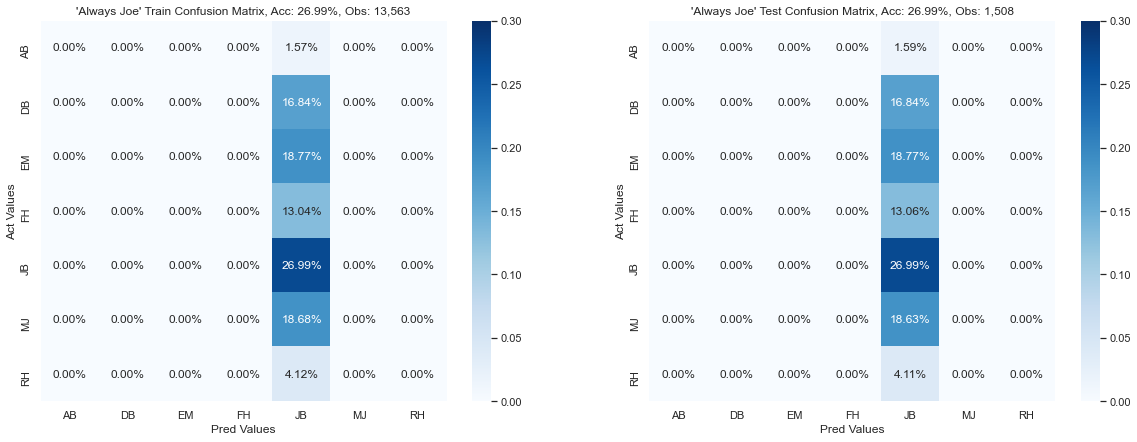

In [10]:
pp_conf_matrices(always_joe_conf_dict, sp_width=10, sp_height=7, max_val=0.3)

So the above shows:
 - 'Always Joe' performs the same on train and test data (as expected given the strat is agnostic to any 'training features'
 - 'Always Joe' only ever chooses Joe - as expected
 - 'Always Joe' results in an accuracy of 26.99% - because 26.99% of the time the 'prediction' of Joe is correct
 
Now we can have a look at the random guess strat.

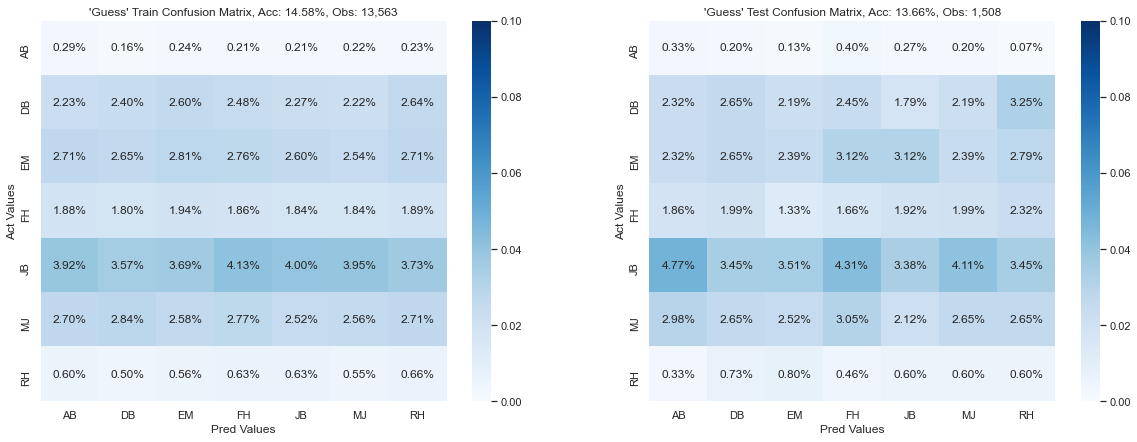

In [11]:
pp_conf_matrices(guess_conf_dict, sp_width=10, sp_height=7, max_val=0.1)

As expected, it is quite evenly distributed chaos with an accuracy of around 14% - which is just 1/7 as expected from a uniformly random guessing process. If we sum each of the columns we get the same % as we 'predict' each author with equal probability.

__So 27% is our benchmark to beat using really naive measures. Can we beat it?__

__Process__

We so far have some raw data - for each model, let's assume we can choose a feature set from a pre-defined set of features. They all have access, but each one we can hone to improve.

So, distinct steps:
 - Train / Test Split: Let's do this first with stratification so we have no 'leakage' and can get onto k-folds after
 - Pre-processing the data to form 'features' and keeping track of the mappings for new col names etc
   - In here we will need to handle continuous, bool and class vars separately and store their encoders/transformers
 - Creating our _actual_ training and test data based on the new transformed data
 - Fitting the model
 - Using the model to make predictions we can assess
 - Assessing the model using metrics
 - Comparing models based on these metrics

## 3. Create Data Pipeline

### 3a. Define and Split the Data

First we are going to define which columns we care about and split the data - this does not need to be part of the pipeline.

In [12]:
# define different columns
y_col = 'Author'
X_cols = ['Hour', 'WordCount', 'TimeSinceLastMessSeconds', 'SelfReply', 'ContainsContent', 'ContainsLaughWord', 'ContainsLolWord', 'OnlyLaughWord', 'PrevAuthor'] #, 'ContentSource']
# form new df
df_pred = df[[y_col] + X_cols]

Now let's split the data into the different variable types that will need some kind of pre-processing

In [13]:
# get numeric features for scaling
numeric_features = df_pred.select_dtypes(include=['int64', 'float64']).columns
# get cat features for encoding, ex y_col
categorical_features = df_pred.select_dtypes(include=['object']).drop(y_col, axis=1).columns
# define boo features
bool_features = df_pred.select_dtypes(include=['bool']).columns

In [14]:
# define X and y raw data
X = df_pred.drop(y_col, axis=1)
y = df_pred[y_col]

# as y is a cat variable, let's encode it pre-split
le = LabelEncoder()
label_encoder = le.fit(y)
y = label_encoder.transform(y)

# perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123, stratify=y)

### 3b. Define Transformers

__Numerical Variables__

First up, let's:
 - input any missing values with the median value
 - standardise these (subtract mean, scale by std dev) using StandardScaler

In [15]:
# create a numerical transformer
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

__Categorical Variables__

Let's:
 - input any missing values with the value 'missing'
 - One Hot Encode them

In [16]:
# cat transformer using one hot
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='error', drop='first'))])

Now we create a preprocessor object which will conduct these pre-defined preprocesses on our data

In [74]:
# define column preprocesser with passthrough argument for remainder cols
# ensures when ColTrans is called we don't drop un-trans'ed cols
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough'
)

In [75]:
pipe_sk = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression())])

In [76]:
# model = pipe.fit(X_train, y_train)
model_sk = pipe_sk.fit(X_train, y_train)

In [79]:
df['Author'].sort_values().unique()

array(['AB', 'DB', 'EM', 'FH', 'JB', 'MJ', 'RH'], dtype=object)

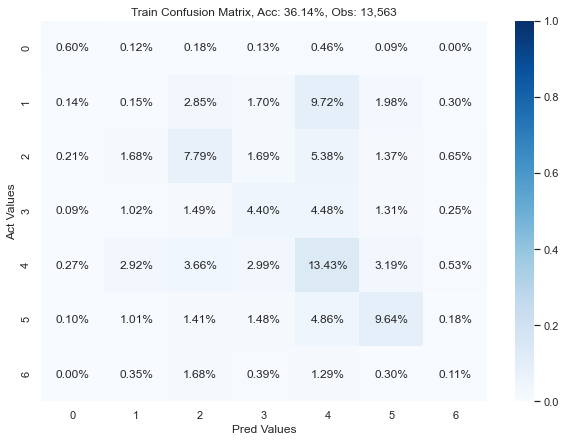

In [77]:
pp_conf_matrix(y_train, model_sk.predict(X_train), label='Train');

In [ ]:
ce.fit_transform()

In [ ]:
encoder_list = [ce.backward_difference.BackwardDifferenceEncoder, 
               ce.basen.BaseNEncoder,
               ce.binary.BinaryEncoder,
                ce.cat_boost.CatBoostEncoder,
                ce.hashing.HashingEncoder,
                ce.helmert.HelmertEncoder,
                ce.james_stein.JamesSteinEncoder,
                ce.one_hot.OneHotEncoder,
                ce.leave_one_out.LeaveOneOutEncoder,
                ce.m_estimate.MEstimateEncoder,
                ce.ordinal.OrdinalEncoder,
                ce.polynomial.PolynomialEncoder,
                ce.sum_coding.SumEncoder,
                ce.target_encoder.TargetEncoder,
                ce.woe.WOEEncoder
                ]
for encoder in encoder_list:
    
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                              ('woe', encoder())])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=500))])
    
    model = pipe.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print(encoder)
    print(f1_score(y_test, y_pred, average='macro'))

In [121]:
df_pred.select_dtypes(include='object')

,Author,PrevAuthor
0,JB,JB
1,JB,JB
2,JB,JB
3,DB,JB
4,DB,DB
...,...,...
15066,DB,RH
15067,JB,DB
15068,JB,JB
15069,EM,JB


## 3. Feature Selection / Creation

Before we start exploring the various models to try and:
 - consume input data
 - attempt (in various ways) to utilise varation in that input data to 'discriminate' between classes
 - make prediction per message which we can amalgamate and display overall output in confusion matrices
 
let's define, and possibly transform, our input data to create a feature set which we can use to train the models.

In [93]:
# define different column types
pred_col = ['Author']
cont_feat_cols = ['Hour', 'WordCount'] #, 'TimeSinceLastMessSeconds']
bool_feat_cols = ['SelfReply', 'ContainsContent', 'ContainsLaughWord', 'ContainsLolWord', 'OnlyLaughWord']
# class_feat_cols = ['PrevAuthor'] #, 'ContentSource']

# get only the columns we care about
df_pred = df[pred_col + cont_feat_cols + bool_feat_cols + class_feat_cols]

Now we need to do a bit of variable pre-processing, particularly:
 - convert the boolean cols to 0,1
 - convert the class based feature columns to one hot encoded cols

In [94]:
for col in bool_feat_cols:
    df_pred[col] = np.where(df_pred[col], 1, 0)

In [95]:
# col map dict
one_hot_col_map = {}

for col in class_feat_cols:
    # create encoder instance and encode
    one_hot_encoder = OneHotEncoder(drop='first')
    # get col labels
    new_col_names = [col+'_'+x for x in df_pred[col].sort_values().unique()][1:]
    # fit encoder
    new_vals = one_hot_encoder.fit_transform(df_pred[[col]]).toarray()
    df_new_cols = pd.DataFrame(new_vals, columns=new_col_names)
    df_pred = df_pred.join(df_new_cols)
    # add encoder to dict
    one_hot_col_map[col] = new_col_names

In [96]:
feat_cols = cont_feat_cols + bool_feat_cols #+ [item for sublist in one_hot_col_map.values() for item in sublist]

In [97]:
# test only 10% of messages, use 90% to train the models
test_frac = 1/10
seed = 123
# split the data
X_train, X_test, y_train, y_test = train_test_split(df_pred[feat_cols], df_pred[pred_col], test_size=test_frac, random_state=seed, stratify=df_pred[pred_col])

## 3. First Up: Multinomial Logistic Regression

Simple linear regression usually being a first go-to of non-classification problems, let's use the mulitnomial logit version to have a stab at this classification problem. First, we need to define a set of features to train the model.

In [98]:
# add_int = True
sm_model = sm.MNLogit(y_train, (sm.add_constant(X_train) if add_int else X_train))
# fit the model
sm_model = sm_model.fit(method='lbfgs')

In [99]:
statsmodels_pretty_print(sm_model, alpha=0.05, dp=4, model_overview=True, param_sort_cols=['Sig', 'coef'])


__Estimating a Multinomial Logit model__
<br>
__Model Overview__
<br>
Assume underlying categorical variable $y_i, i=1...K$ has a multinomial distribution - we want to estimate for a set of data $[y_i, X_i]$ a set of K probabilities, $P(y_i = k)$
<br>
Underlying probability distribution:
<br>
$$P(y_i = k) = p_1^{x_1} \cdot p_2^{x_2} \cdot ... p_n^{x_n}$$
where $x_i = 1$ when $k = x_i$
<br>
We estimate this using a logit model - we model the log odds i.e. the log of the ratio of probabilities as a linear function:
<br>
$$Odds_k = \frac{P(y_i=k)}{P(y_i=1)} = e^{\alpha + \beta X_i}$$
<br>
where we fix one case $y_i = 1$ as the base case to which all else is compared i.e. likelihood vs base
<br>
Utilising a log link function we thus use MLE to estimate the following equation:
$$ln(Odds_k) = ln(\frac{P(y_i=k)}{P(y_i=1)}) = \alpha + \beta X_i$$
<br>
In practise we estimate the following:
<br>
$$P(y_i = k) = \frac{e^{\alpha_k + \beta_k X_i}}{\sum_{i=1}^{K}e^{\alpha_k + \beta_k X_i}}$$
<br>
i.e. estimate a set of $[\alpha_k, \beta_k]$ params for each outcome k, utilising softmax to normalise $\sum_{i=1}^K{P(y_i = k)} = 1$
<br>
Coefficients can be interpreted as the increase in likelihood of event k happening (vs base) for a 1 unit increase in the variable i.e. for $x_m$ feature: 
<br>
$$\frac{Odds_{k,x_m+1}}{Odds_k} = e^{\beta_m}$$
<br>
Solving steps:
- Estimate values for all $\alpha_k$ and $\beta_k$
- Compute the implied probabilities for all obs for all K
- Use max likelihood function to compute likelihood
- Use max likelihood function to see how we did - then iterate to maximise likelihood function


__Model Output__

Author            P(y=DB)/P(y=AB)                                   \
                             coef      lb      ub       p        z   
const                      1.1130  0.7199  1.7205  0.6301   0.4816   
Hour                       1.1976  1.1598  1.2366  0.0000  11.0206   
WordCount                  0.9594  0.9300  0.9897  0.0090  -2.6134   
SelfReply                  0.6080  0.4685  0.7889  0.0002  -3.7440   
ContainsContent            0.7692  0.5173  1.1436  0.1947  -1.2969   
ContainsLaughWord          1.0873  0.4195  2.8180  0.8632   0.1723   
ContainsLolWord            1.0540  0.3465  3.2059  0.9261   0.0927   
OnlyLaughWord              1.0542  0.3737  2.9737  0.9205   0.0998   

Author            P(y=EM)/P(y=AB)                                   \
                             coef      lb      ub       p        z   
const                      0.9617  0.6243  1.4817  0.8596  -0.1769   
Hour                       1.1839  1.1468  1.2222  0.0000  10.3860   
WordCount                  1.0120  0.9820  1.0429  0.4385   0.7747   
SelfReply                  1.1083  0.8594  1.4293  0.4281   0.7924   
ContainsContent            0.9381  0.6333  1.3896  0.7501  -0.3185   
ContainsLaughWord          0.8794  0.3351  2.3078  0.7940  -0.2611   
ContainsLolWord            1.0732  0.3449  3.3399  0.9029   0.1220   
OnlyLaughWord              0.8878  0.3094  2.5472  0.8249  -0.2213   

Author            P(y=FH)/P(y=AB)                                   \
                             coef      lb      ub       p        z   
const                      0.9274  0.5956  1.4440  0.7386  -0.3337   
Hour                       1.1911  1.1531  1.2303  0.0000  10.5792   
WordCount                  0.9332  0.9035  0.9640  0.0000  -4.1819   
SelfReply                  0.8660  0.6661  1.1258  0.2824  -1.0749   
ContainsContent            1.0094  0.6789  1.5009  0.9629   0.0465   
ContainsLaughWord          1.1448  0.4349  3.0136  0.7843   0.2738   
ContainsLolWord            0.9276  0.3013  2.8561  0.8958  -0.1310   
OnlyLaughWord              1.2378  0.4324  3.5435  0.6910   0.3975   

Author            P(y=JB)/P(y=AB)                                   \
                             coef      lb      ub       p        z   
const                      1.4696  0.9616  2.2461  0.0753   1.7789   
Hour                       1.1743  1.1380  1.2118  0.0000  10.0177   
WordCount                  1.0037  0.9742  1.0340  0.8100   0.2404   
SelfReply                  1.1343  0.8830  1.4573  0.3241   0.9862   
ContainsContent            1.3756  0.9381  2.0172  0.1025   1.6328   
ContainsLaughWord          1.1948  0.4677  3.0522  0.7099   0.3720   
ContainsLolWord            1.0155  0.3385  3.0466  0.9781   0.0274   
OnlyLaughWord              1.0733  0.3862  2.9830  0.8920   0.1357   

Author            P(y=MJ)/P(y=AB)                                  \
                             coef      lb      ub       p       z   
const                      1.2040  0.7820  1.8538  0.3991  0.8432   
Hour                       1.1370  1.1014  1.1738  0.0000  7.9046   
WordCount                  1.0090  0.9790  1.0398  0.5618  0.5802   
SelfReply                  2.1526  1.6707  2.7734  0.0000  5.9297   
ContainsContent            1.1965  0.8104  1.7666  0.3669  0.9024   
ContainsLaughWord          0.8348  0.3117  2.2355  0.7193 -0.3594   
ContainsLolWord            0.9471  0.2962  3.0290  0.9270 -0.0916   
OnlyLaughWord              0.8852  0.3014  2.5998  0.8245 -0.2218   

Author            P(y=RH)/P(y=AB)                                  
                             coef      lb      ub       p       z  
const                      0.7181  0.4389  1.1749  0.1874 -1.3182  
Hour                       1.1227  1.0834  1.1635  0.0000  6.3654  
WordCount                  0.9643  0.9303  0.9995  0.0469 -1.9876  
SelfReply                  0.7535  0.5608  1.0123  0.0603 -1.8785  
ContainsContent            0.9123  0.5855  1.4217  0.6852 -0.4054  
ContainsLaughWord          0.

In [113]:
sm_model.predict(sm.add_constant(X_train))

,0,1,2,3,4,5,6
3409,0.035699,0.069428,0.142780,0.095306,0.299279,0.317614,0.039893
15007,0.028836,0.189604,0.188491,0.129621,0.252706,0.149059,0.061682
3394,0.027014,0.209645,0.168376,0.160079,0.233303,0.134743,0.066841
3689,0.006640,0.175068,0.264438,0.085985,0.300939,0.135517,0.031413
11528,0.015817,0.196918,0.208005,0.124646,0.265515,0.139111,0.049987
...,...,...,...,...,...,...,...
11214,0.004446,0.192885,0.166494,0.182091,0.309276,0.108944,0.035864
14969,0.018106,0.231012,0.123499,0.215700,0.276545,0.086277,0.048860
6827,0.034142,0.223210,0.127224,0.187437,0.278487,0.092196,0.057304
9181,0.017424,0.213793,0.184556,0.151972,0.245468,0.130053,0.056733


In [36]:
guess_conf_dict = [{'act': y_train.values,'pred': sm_model.predict(X_train), 'label': "Train"},
                   {'act': y_test.values,'pred': sm_model.predict(sm.add_constant(X_test)), 'label': "Test"}]

TypeError: unhashable type: 'numpy.ndarray'

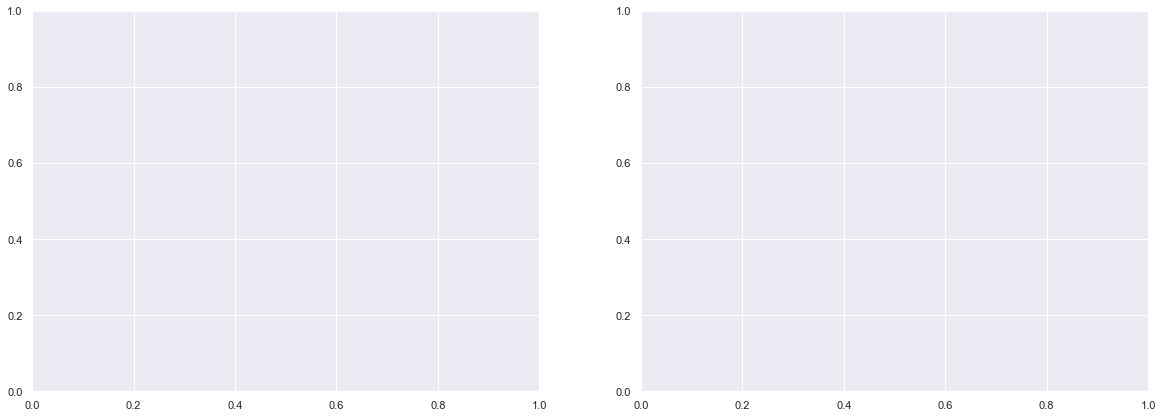

In [37]:
pp_conf_matrices(guess_conf_dict, sp_width=10, sp_height=7, max_val=0.1)